In [104]:
# import libraries
from importlib import reload
from data import northWindConnector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
reload(northWindConnector);

## Investigate data

In [106]:
db = northWindConnector.DbConnector()

In [107]:
db.list_tables()

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [108]:
tables = db.list_tables()
for table in tables:
    print(f'\n==={table}===\n')
    columns = db.list_column_names(table)
    for column in columns:
        print(column)


===Employee===

Id
LastName
FirstName
Title
TitleOfCourtesy
BirthDate
HireDate
Address
City
Region
PostalCode
Country
HomePhone
Extension
Photo
Notes
ReportsTo
PhotoPath

===Category===

Id
CategoryName
Description

===Customer===

Id
CompanyName
ContactName
ContactTitle
Address
City
Region
PostalCode
Country
Phone
Fax

===Shipper===

Id
CompanyName
Phone

===Supplier===

Id
CompanyName
ContactName
ContactTitle
Address
City
Region
PostalCode
Country
Phone
Fax
HomePage

===Order===

Id
CustomerId
EmployeeId
OrderDate
RequiredDate
ShippedDate
ShipVia
Freight
ShipName
ShipAddress
ShipCity
ShipRegion
ShipPostalCode
ShipCountry

===Product===

Id
ProductName
SupplierId
CategoryId
QuantityPerUnit
UnitPrice
UnitsInStock
UnitsOnOrder
ReorderLevel
Discontinued

===OrderDetail===

Id
OrderId
ProductId
UnitPrice
Quantity
Discount

===CustomerCustomerDemo===

Id
CustomerTypeId

===CustomerDemographic===

Id
CustomerDesc

===Region===

Id
RegionDescription

===Territory===

Id
TerritoryDescription

In [109]:
db.load_table_as_df('OrderDetail')

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [110]:
# obtain necessary data
query ="""
SELECT Quantity, Discount FROM OrderDetail;
"""

df = db.load_query_as_df(query)

In [111]:
df.Discount.nunique()

11

In [112]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

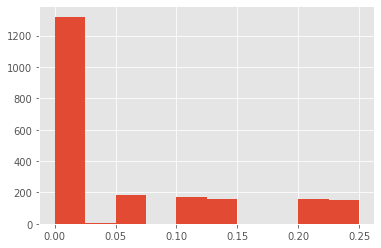

In [113]:
df.Discount.hist()
plt.show()

We'll focus on the most frequent discount rates. 

In [114]:
# I know there has to be a more efficient way to do this
df.drop(df.loc[df['Discount']==0.06].index, inplace=True)
df.drop(df.loc[df['Discount']==0.04].index, inplace=True)
df.drop(df.loc[df['Discount']==0.01].index, inplace=True)
df.drop(df.loc[df['Discount']==0.02].index, inplace=True)
df.drop(df.loc[df['Discount']==0.03].index, inplace=True)

## ANOVA
Since we are looking to analyze the variance from discount rate to discount rate, it makes sense to me to perform ANOVA test.

### Define Hypothesis 
* Null Hypothesis **H0: There is no difference in the average quantity of products sold by discount rate**.
* Alternative Hypothesis **HA: At least one of the discount rates has a different average quantity of products sold.**

$\alpha$ = 0.05

### Assumptions
* The samples come from a normal distribution
* The variance is equal
* Independent Samples

In [124]:
# perform test
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats

In [125]:
anova = ols('Quantity ~ Discount', data=df).fit()
table = sm.stats.anova_lm(anova, typ=2)
table

,sum_sq,df,F,PR(>F)
Discount,12621.238965,1.0,35.487951,2.991487e-09
Residual,762866.181622,2145.0,NaN,NaN


In [126]:
#Checking for normality 
stats.shapiro(anova.resid)

ShapiroResult(statistic=0.8587857484817505, pvalue=3.172497684277456e-40)

In [127]:
#Checking if 'Variance is equal'
stats.levene(df['Quantity'][df['Discount'] == 0.00],
             df['Quantity'][df['Discount'] == 0.05],
             df['Quantity'][df['Discount'] == 0.10],
             df['Quantity'][df['Discount'] == 0.15],
             df['Quantity'][df['Discount'] == 0.20],
             df['Quantity'][df['Discount'] == 0.25])

LeveneResult(statistic=2.9943951679841643, pvalue=0.010664285577385134)

### Tukey Testing

In [135]:
mc = MultiComparison(df['Quantity'], df['Discount'])
results = mc.tukeyhsd()

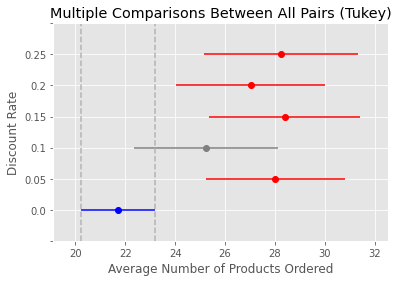

In [134]:
#Lets recall that 0.00 means no discount while every other discount rate means some ammount of discount.
results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Rate', xlabel='Average Number of Products Ordered');


## Conclusion

There's significant statistical difference to reject the Null Hypothesis.